### Input

In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import helpfunction as helper
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import validation_curve
import pickle
import copy
import gc

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

### Constants

In [4]:
run = 1
run_str = "run" + str(run)

<IPython.core.display.Javascript object>

In [5]:
pot_target = 10.1e20  # Run1+Run3
lee_focus = 1

<IPython.core.display.Javascript object>

In [6]:
x_sce_magic = 1.03

<IPython.core.display.Javascript object>

In [7]:
max_trk_score = 0.3
min_cluster_frac = 0.4
min_shw_e = 75  # MeV
max_cosmic_impact = 15
min_topo_score = 0.15

<IPython.core.display.Javascript object>

In [8]:
retrain = True
train_run1 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0"],
    "run3": ["elee_high", "elee_low", "nu", "nue", "ncpi0", "ccpi0"],
}
train_run3 = {
    "run1": ["ccpi0", "elee_high", "elee_low", "ncpi0", "nue", "nu"],
    "run3": ["elee_high", "elee_low", "ncpi0", "ccpi0"],
}
plot_samples = ["nu", "nue", "on", "off", "dirt"]
train_samples = {"run1": train_run1, "run3": train_run3}
seed = 7
test_size = 0.25

<IPython.core.display.Javascript object>

### Load Samples

In [9]:
input_dir = "./input/16Jan/".format(run)
output_dir = "./output/run{}/".format(run)
model_dir = "./models/run{}/".format(run)

<IPython.core.display.Javascript object>

In [10]:
%%time
data_run1 = pickle.load(open(input_dir+"run1_slimmed.pckl".format(run), 'rb'))
data_run3 = pickle.load(open(input_dir+"run3_slimmed.pckl".format(run), 'rb'))
data_samples = {
    "run1": data_run1,
    "run3": data_run3,
}

CPU times: user 1.21 s, sys: 2.11 s, total: 3.32 s
Wall time: 3.32 s


<IPython.core.display.Javascript object>

In [11]:
sample_info = {}
for s in plot_samples:
    sample_info[s] = data_samples[run_str][s]

# Prepare training data set
sample_info["train"] = {}
daughter_df_list = []
train_names = []
num_entries = 0
for run_i in train_samples[run_str]:
    for sample_i in train_samples[run_str][run_i]:
        daughter_df_list.append(data_samples[run_i][sample_i]["daughters"])
        num_entries += data_samples[run_i][sample_i]["numentries"]
        train_names.append(run_i + "_" + sample_i)
sample_info["train"]["daughters"] = pd.concat(
    daughter_df_list, sort=False, copy=True, verify_integrity=True, keys=train_names
)
sample_info["train"]["daughters"].index.names = ["sample", "event", "daughter"]
sample_info["train"]["numentries"] = num_entries
print("Training set constructed with {} entries.".format(num_entries))

# Be friendly to your memory!
del data_run1
del data_run3
del data_samples
del daughter_df_list
gc.collect()

Training set constructed with 1733669 entries.


51

<IPython.core.display.Javascript object>

In [12]:
pot_scale = pot_target / sample_info["on"]["pot"]

<IPython.core.display.Javascript object>

### Explore Tree

In [13]:
fields = sample_info["nue"]["fields"]
shr_fields = [f for f in fields if f.startswith("shr_") and f.endswith("_v")]
trk_fields = [f for f in fields if f.startswith("trk_") and f.endswith("_v")]
backracked_fields = [f for f in fields if f.startswith("backtracked_")]
mc_fields = [f for f in fields if f.startswith(("true_", "mc_"))]
other_fields = (
    set(fields)
    - set(shr_fields)
    - set(trk_fields)
    - set(backracked_fields)
    - set(mc_fields)
)

<IPython.core.display.Javascript object>

In [14]:
trk_fields

['trk_score_v',
 'trk_bragg_p_v',
 'trk_bragg_mu_v',
 'trk_bragg_mip_v',
 'trk_pida_v',
 'trk_pid_chipr_v',
 'trk_pid_chipi_v',
 'trk_pid_chika_v',
 'trk_pid_chimu_v',
 'trk_bragg_p_u_v',
 'trk_bragg_mu_u_v',
 'trk_bragg_mip_u_v',
 'trk_pida_u_v',
 'trk_pid_chipr_u_v',
 'trk_pid_chipi_u_v',
 'trk_pid_chika_u_v',
 'trk_pid_chimu_u_v',
 'trk_bragg_p_v_v',
 'trk_bragg_mu_v_v',
 'trk_bragg_mip_v_v',
 'trk_pida_v_v',
 'trk_pid_chipr_v_v',
 'trk_pid_chipi_v_v',
 'trk_pid_chika_v_v',
 'trk_pid_chimu_v_v',
 'trk_pfp_id_v',
 'trk_dir_x_v',
 'trk_dir_y_v',
 'trk_dir_z_v',
 'trk_start_x_v',
 'trk_start_y_v',
 'trk_start_z_v',
 'trk_sce_start_x_v',
 'trk_sce_start_y_v',
 'trk_sce_start_z_v',
 'trk_end_x_v',
 'trk_end_y_v',
 'trk_end_z_v',
 'trk_sce_end_x_v',
 'trk_sce_end_y_v',
 'trk_sce_end_z_v',
 'trk_distance_v',
 'trk_theta_v',
 'trk_phi_v',
 'trk_len_v',
 'trk_mcs_muon_mom_v',
 'trk_range_muon_mom_v',
 'trk_energy_proton_v',
 'trk_energy_muon_v',
 'trk_calo_energy_u_v',
 'trk_calo_energy_v_v'

<IPython.core.display.Javascript object>

In [15]:
shr_fields

['shr_dedx_u_v',
 'shr_dedx_v_v',
 'shr_dedx_y_v',
 'shr_energy_u_v',
 'shr_energy_v_v',
 'shr_energy_y_v',
 'shr_pfp_id_v',
 'shr_start_x_v',
 'shr_start_y_v',
 'shr_start_z_v',
 'shr_dist_v',
 'shr_start_U_v',
 'shr_start_V_v',
 'shr_px_v',
 'shr_py_v',
 'shr_pz_v',
 'shr_openangle_v',
 'shr_theta_v',
 'shr_phi_v',
 'shr_pitch_u_v',
 'shr_pitch_v_v',
 'shr_pitch_y_v',
 'shr_tkfit_nhits_v',
 'shr_tkfit_start_x_v',
 'shr_tkfit_start_y_v',
 'shr_tkfit_start_z_v',
 'shr_tkfit_start_U_v',
 'shr_tkfit_start_V_v',
 'shr_tkfit_theta_v',
 'shr_tkfit_phi_v',
 'shr_tkfit_pitch_u_v',
 'shr_tkfit_pitch_v_v',
 'shr_tkfit_pitch_y_v',
 'shr_tkfit_dedx_u_v',
 'shr_tkfit_dedx_v_v',
 'shr_tkfit_dedx_y_v',
 'shr_tkfit_gap10_dedx_u_v',
 'shr_tkfit_gap10_dedx_v_v',
 'shr_tkfit_gap10_dedx_y_v',
 'shr_tkfit_dedx_nhits_u_v',
 'shr_tkfit_dedx_nhits_v_v',
 'shr_tkfit_dedx_nhits_y_v',
 'shr_moliere_avg_v',
 'shr_moliere_rms_v',
 'shr_spacepoint_start_x_v',
 'shr_spacepoint_start_y_v',
 'shr_spacepoint_start_z_v

<IPython.core.display.Javascript object>

In [16]:
backracked_fields

['backtracked_pdg',
 'backtracked_e',
 'backtracked_purity',
 'backtracked_completeness',
 'backtracked_overlay_purity',
 'backtracked_px',
 'backtracked_py',
 'backtracked_pz',
 'backtracked_start_x',
 'backtracked_start_y',
 'backtracked_start_z',
 'backtracked_start_t',
 'backtracked_start_U',
 'backtracked_start_V',
 'backtracked_start_Y',
 'backtracked_sce_start_x',
 'backtracked_sce_start_y',
 'backtracked_sce_start_z',
 'backtracked_sce_start_U',
 'backtracked_sce_start_V',
 'backtracked_sce_start_Y']

<IPython.core.display.Javascript object>

In [17]:
other_fields

{'CosmicDirAll2DEnds',
 'CosmicDirAll2DOvlp',
 'CosmicDirAll3D',
 'CosmicIP',
 'CosmicIPAll2DEnds',
 'CosmicIPAll2DOvlp',
 'CosmicIPAll3D',
 'NeutrinoEnergy0',
 'NeutrinoEnergy1',
 'NeutrinoEnergy2',
 'SliceCaloEnergy0',
 'SliceCaloEnergy1',
 'SliceCaloEnergy2',
 '_elecclusters_U_N',
 '_elecclusters_U_charge',
 '_elecclusters_V_N',
 '_elecclusters_V_charge',
 '_elecclusters_Y_N',
 '_elecclusters_Y_charge',
 '_opfilter_pe_beam',
 '_opfilter_pe_veto',
 'bdt_cosmic',
 'bdt_ext',
 'bdt_global',
 'bdt_nuNCpi0',
 'bdt_numuCC',
 'bdt_numuCCpi0',
 'best_cosmic_flashmatch_score',
 'best_obviouscosmic_flashmatch_score',
 'category',
 'ccnc',
 'contained_fraction',
 'contained_sps_ratio',
 'cosmic_flashmatch_score_v',
 'crthitpe',
 'crtveto',
 'dmc_boundary',
 'dshr_boundary',
 'dshr_x_boundary',
 'dshr_y_boundary',
 'dshr_z_boundary',
 'dtrk',
 'dtrk_boundary',
 'dtrk_x_boundary',
 'dtrk_y_boundary',
 'dtrk_z_boundary',
 'dvtx',
 'dvtx_boundary',
 'dvtx_x_boundary',
 'dvtx_y_boundary',
 'dvtx_z_

<IPython.core.display.Javascript object>

In [18]:
# search through fields:
[f for f in fields if "truthFiducial" in f]

['truthFiducial']

<IPython.core.display.Javascript object>

In [19]:
sample_info["on"]["daughters"].keys()

Index(['run', 'sub', 'evt', 'topological_score', 'n_pfps', 'n_showers',
       'n_tracks', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y',
       'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'reco_nu_vtx_z',
       'crtveto', 'crthitpe', 'slclustfrac', 'nu_flashmatch_score', 'category',
       'nslice', 'contained_sps_ratio', 'slpdg', 'SliceCaloEnergy2',
       'NeutrinoEnergy2', 'secondshower_U_nhit', 'secondshower_V_nhit',
       'secondshower_Y_nhit', 'secondshower_Y_vtxdist', 'secondshower_Y_dot',
       'secondshower_Y_dir', 'secondshower_Y_eigenratio', 'hits_ratio',
       'contained_fraction', 'n_showers_contained', 'n_tracks_contained',
       'shrclusdir2', 'shrsubclusters2', 'shrclusfrac2', 'extra_energy_y',
       'CosmicIP', 'ismerged', 'merge_bestdot', 'merge_bestdist',
       'trk_score_v', 'trk_distance_v', 'trk_theta_v', 'trk_phi_v',
       'trk_len_v', 'trk_llr_pid_score_v', 'trk_mcs_muon_mom_v',
       'trk_range_muon_mom_v', 'trk_energy_proton_v', 'trk_calo_energ

<IPython.core.display.Javascript object>

### Add fields

In [20]:
%%time
# For all samples
for k, v in sample_info.items():
    print(k)
    grouper='event'
    if k=='train':
        grouper=['event','sample']
    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
       helper.is_fid(
           *v["daughters"][
               ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
           ]
           .xs(0, level="daughter")
           .values.T
       ),
       v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )
    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby(grouper, sort=False).transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby(grouper, sort=False).transform(min)
    )
    # Add pfp at vtx:
    v["daughters"]["n_pfpvtx"] = v["daughters"].eval("trk_distance_v<3 & trk_distance_v>=0")
    v["daughters"]["n_pfpvtx"] = v["daughters"]['n_pfpvtx'].groupby(grouper, sort=False).transform(sum)
    v["daughters"]["n_pfp_farvtx"] = v["daughters"].eval("n_pfps-n_pfpvtx")
    # Add shower distance: 
    #v["daughters"]["shr_dist_v"] = v["daughters"].eval('sqrt((shr_tkfit_start_x_v-reco_nu_vtx_x)**2+ (shr_tkfit_start_y_v-reco_nu_vtx_y)**2 + (shr_tkfit_start_z_v-reco_nu_vtx_z)**2)')
    # Add second shower total hits:
    v["daughters"]["secondshower_nhit"] = v["daughters"].eval("secondshower_U_nhit+secondshower_V_nhit+secondshower_Y_nhit")
    # Add electron candidate check
    e_cand_str = 'pfnplanehits_U>0 & pfnplanehits_V>0 & pfnplanehits_Y>0 & trk_score_v<@max_trk_score & shr_tkfit_dedx_nhits_y_v>0 & pfp_generation_v==2'    
    data = v["daughters"][
               [
                   "pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y",
                   "trk_score_v",'shr_tkfit_dedx_nhits_y_v',
                   "shr_dist_v", 'pfp_generation_v', "shr_energy_y_v"
               ]
           ]
    electron_candidate = data.eval(e_cand_str)
    e_cand_maxe = data[electron_candidate]["shr_energy_y_v"].groupby(grouper, sort=False).transform(max) == data[electron_candidate]["shr_energy_y_v"]
    v["daughters"]["e_candidate"] = False
    v["daughters"].loc[e_cand_maxe[e_cand_maxe == True].index, "e_candidate"] = True
    # Add weighted dedx:
    dedx_cols = ["shr_tkfit_dedx_u_v",
                   "shr_tkfit_dedx_v_v",
                   "shr_tkfit_dedx_y_v",
                   'shr_tkfit_nhits_v',
                   "shr_tkfit_dedx_nhits_u_v",
                   "shr_tkfit_dedx_nhits_v_v",
                   "shr_tkfit_dedx_nhits_y_v"]
    v["daughters"][dedx_cols]=v["daughters"][dedx_cols].clip(lower=0)
    str_dedx_weighted_mean='(shr_tkfit_dedx_u_v*shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_v_v*shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_y_v*shr_tkfit_dedx_nhits_y_v)/(shr_tkfit_dedx_nhits_u_v+shr_tkfit_dedx_nhits_v_v+shr_tkfit_dedx_nhits_y_v)'
    v["daughters"]['shr_tkfit_dedx_wm_v']= v["daughters"].eval(str_dedx_weighted_mean)
    # Add the number of hits per length:
    v["daughters"]['hits_per_tklen_v']= v["daughters"].eval('pfnhits/trk_len_v')
    # Add the ratio between dedx at 0cm and 1cm:
    v["daughters"]['shr_tkfit_ratiogap_dedx_y_v']= v["daughters"].eval('shr_tkfit_dedx_y_v/shr_tkfit_gap10_dedx_y_v')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_subclusters_v']= v["daughters"].eval('pfpplanesubclusters_U+pfpplanesubclusters_V+pfpplanesubclusters_Y')
    # Add the sum of shower subclusters:
    v["daughters"]['shr_tkfit_hitratio_v']= v["daughters"].eval('shr_tkfit_nhits_v/pfnhits')
    # Explore mcs muon momentum:
    v["daughters"]['trk_muon_hypothesis_ratio_v']= v["daughters"].eval('trk_mcs_muon_mom_v/trk_calo_energy_y_v')
    
    # Add muon veto:
    q_muon_select = "(trk_llr_pid_score_v>0.4 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4)"
    v["daughters"]['mu_candidate']= v["daughters"].eval(q_muon_select)
    v["daughters"]["mu_candidate_event"] = v["daughters"]['mu_candidate'].groupby(grouper, sort=False).transform(max)

nu
nue
on
off
dirt
train
CPU times: user 12.9 s, sys: 630 ms, total: 13.5 s
Wall time: 7.42 s


<IPython.core.display.Javascript object>

In [21]:
%%time
# For MC samples
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add distance between reco_sce and true vertex
        data = (
            v["daughters"][
                [
                    "reco_nu_vtx_sce_x",
                    "reco_nu_vtx_sce_y",
                    "reco_nu_vtx_sce_z",
                    "true_nu_vtx_x",
                    "true_nu_vtx_y",
                    "true_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        data[0]-=x_sce_magic # Correct x location for the 0.6 sign error
        
        v["daughters"]["true_vtx_distance"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Cross-check vtx distance
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "reco_nu_vtx_x",
                    "reco_nu_vtx_y",
                    "reco_nu_vtx_z",
                ]
            ]
            .xs(0, level="daughter")
            .values.T
        )
        v["daughters"]["true_vtx_distance_check"] = np.repeat(
            np.linalg.norm(data[0:3] - data[3:6], axis=0),
            v["daughters"]["n_pfps"].xs(0, level="daughter"),
        )
        # Add the distance between the true neutrino vertex and the reconstructed shower start point
        data = (
            v["daughters"][
                [
                    "true_nu_vtx_sce_x",
                    "true_nu_vtx_sce_y",
                    "true_nu_vtx_sce_z",
                    "shr_tkfit_start_x_v",
                    "shr_tkfit_start_y_v",
                    "shr_tkfit_start_z_v",
                ]
            ]
            .values.T
        )
        v["daughters"]["true_shower_distance"] = np.linalg.norm(data[0:3] - data[3:6], axis=0)
        
        # Add the modified purity/completeness to account for overlay.
        overlay_mask = v["daughters"].eval('backtracked_overlay_purity>backtracked_purity')
        v["daughters"].loc[overlay_mask, 'backtracked_pdg'] = 0
        v["daughters"].loc[overlay_mask, 'backtracked_purity'] = v["daughters"].loc[overlay_mask, 'backtracked_overlay_purity']
        v["daughters"].loc[overlay_mask, 'backtracked_completeness'] = 0

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/numpy/linalg/linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


CPU times: user 6.1 s, sys: 2.39 s, total: 8.49 s
Wall time: 4.75 s


<IPython.core.display.Javascript object>

In [22]:
%%time
# For MC samples, fields needed as training labels:
for k, v in sample_info.items():
    if k not in helper.data_samples:
        # Add training labels and weights
        e_cand = v["daughters"]['e_candidate']
        e_good = v["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.8 & backtracked_completeness>0.8')
        e_cand_bad = v["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11')
        other_bad = v["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
        other_neutral = v["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
        v["daughters"]['train_weight'] = v["daughters"].eval('weightSplineTimesTune+leeweight*@lee_focus') # weight low energy electrons a bit higher
        v["daughters"]['train_weight'] = v["daughters"].eval('train_weight*(1+(75<shr_energy_y_v<400)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
        v["daughters"].loc[e_good, "train_weight"] *= 2 # can be tuned
        v["daughters"].loc[other_neutral, "train_weight"] = 1 # can be tuned
        
        v["daughters"]['train_label'] = 1
        v["daughters"].loc[e_cand_bad, "train_label"] = 0
        v["daughters"].loc[other_bad, "train_label"] = 0
        v["daughters"].loc[other_neutral, "train_label"] = 0

CPU times: user 3.37 s, sys: 77.1 ms, total: 3.44 s
Wall time: 1.74 s


<IPython.core.display.Javascript object>

### Quality cuts / Pre-selection

In [23]:
query_preselect = "e_candidate & \
                   reco_fid_vol & \
                   slclustfrac>@min_cluster_frac & \
                   shr_energy_y_v>@min_shw_e & \
                   CosmicIP>@max_cosmic_impact & \
                   topological_score > @min_topo_score & \
                   ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20"

<IPython.core.display.Javascript object>

In [24]:
%%time
# Passing rate pre-selection
for k, v in sample_info.items():
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"]=999
        
    grouper='event'
    if k=='train':
        grouper=['event','sample']
        v["daughters"]["_closestNuCosmicDist"].fillna(999, inplace=True)
    
    v["daughters"]["preselect"] = v["daughters"].eval(
        query_preselect
    )
    v["daughters"]["preselect"] = v["daughters"]["preselect"].groupby(grouper, sort=False).transform(max)
    
    pass_rate = sum(v["daughters"].eval("e_candidate & preselect"))/v['numentries']
    print(k, "\t{:.2f}%".format(pass_rate * 100))
    
# Passing rate signal, weights applied!
pass_rate = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*weightSpline*nueccinc'))/sum(sample_info["nue"]["mc"]['weightSpline']*sample_info['nue']['mc']['nueccinc'] )
print("Nue signal passing the preselection \t{:.2f}%".format(pass_rate * 100))
nue_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(nue_pass,pot_target))
lee_pass = sum(sample_info["nue"]['daughters'].eval('(e_candidate & preselect)*leeweight*nueccinc'))*sample_info["nue"]['scaling']*pot_scale
print("Nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass,pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & preselect)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & preselect)")) * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(sample_info["nue"]["daughters"].eval("(e_candidate & preselect)*weightSpline*nueccinc"))
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & preselect)")) / purity_denom,
    )
)

nu 	2.46%
nue 	37.03%
on 	0.54%
off 	0.08%
dirt 	0.07%
train 	10.10%
Nue signal passing the preselection 	46.13%
Nue Intrinsic signal passing: 617.551 per 1e+21 POT
Nue LEE signal passing: 29.505 per 1e+21 POT


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Purity MC: 2.8%
Data/MC-ratio: 0.93

CPU times: user 2.91 s, sys: 32 ms, total: 2.94 s
Wall time: 1.56 s


<IPython.core.display.Javascript object>

### Machine Learning Selection

In [25]:
col_train_electron = [
    # "trk_min_cos",
    "shr_dist_v",
    "shr_tkfit_dedx_wm_v",
    "shr_tkfit_dedx_y_v",
    "shr_moliere_avg_v",
    # "shr_tkfit_hitratio_v",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_subclusters_v",
    # "secondshower_nhit",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "ismerged",
    # "merge_bestdist",
    ##"train_weight",
    ##"train_label",
]
col_train_other = [
    "trk_score_v",
    "trk_distance_v",
    # "trk_len_v",
    "trk_llr_pid_score_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    # "hits_per_tklen_v",
    # "shr_tkfit_dedx_wm_v",
    # "shr_moliere_avg_v",
    "pfp_generation_v",
    # "shr_subclusters_v"
    ##"train_weight",
    ##"train_label",
]

col_train_event = [
    "n_showers",
    "n_pfp_farvtx",
    "hits_ratio",
    "contained_fraction",
    "score",
    # "score_other_max",
    "score_other_min",
    "score_other_mean",
    ## nueccinc
    ## train_weight -> use the train weight of the electron candidate
]

<IPython.core.display.Javascript object>

#### Electron training

In [26]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_electron]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [27]:
# fit model no training data
if retrain:
    depth = 5
    model_e = XGBClassifier(max_depth=depth)
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_e.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
    )
    dump(model_e, model_dir + "model_e.pckl")
else:
    model_e = load(model_dir + "model_e.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-error:0.204745	validation_0-logloss:0.649434	validation_1-error:0.204264	validation_1-logloss:0.649947
[1]	validation_0-error:0.19332	validation_0-logloss:0.6141	validation_1-error:0.195261	validation_1-logloss:0.614445
[2]	validation_0-error:0.186366	validation_0-logloss:0.584228	validation_1-error:0.188268	validation_1-logloss:0.584897
[3]	validation_0-error:0.190578	validation_0-logloss:0.55932	validation_1-error:0.19213	validation_1-logloss:0.559973
[4]	validation_0-error:0.189153	validation_0-logloss:0.538087	validation_1-error:0.191467	validation_1-logloss:0.538735
[5]	validation_0-error:0.189732	validation_0-logloss:0.519891	validation_1-error:0.192313	validation_1-logloss:0.520664
[6]	validation_0-error:0.18846	validation_0-logloss:0.503964	validation_1-error:0.191833	validation_1-logloss:0.505221
[7]	validation_0-error:0.186023	validation_0-logloss:0.490452	validation_1-error:0.189708	validation_1-logloss:0.491796
[8]	validation_0-error:0.185238	validation_0-l

[69]	validation_0-error:0.16244	validation_0-logloss:0.374648	validation_1-error:0.168822	validation_1-logloss:0.383468
[70]	validation_0-error:0.162486	validation_0-logloss:0.374463	validation_1-error:0.168685	validation_1-logloss:0.383388
[71]	validation_0-error:0.162288	validation_0-logloss:0.374095	validation_1-error:0.168571	validation_1-logloss:0.383146
[72]	validation_0-error:0.162242	validation_0-logloss:0.373877	validation_1-error:0.168411	validation_1-logloss:0.383038
[73]	validation_0-error:0.16209	validation_0-logloss:0.373714	validation_1-error:0.168205	validation_1-logloss:0.38298
[74]	validation_0-error:0.162014	validation_0-logloss:0.373333	validation_1-error:0.168365	validation_1-logloss:0.382697
[75]	validation_0-error:0.161915	validation_0-logloss:0.373157	validation_1-error:0.168457	validation_1-logloss:0.382658
[76]	validation_0-error:0.161732	validation_0-logloss:0.372883	validation_1-error:0.168388	validation_1-logloss:0.382498
[77]	validation_0-error:0.161664	va

<IPython.core.display.Javascript object>

In [28]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

              precision    recall  f1-score   support

    electron       0.90      0.85      0.88     30201
non_electron       0.71      0.79      0.75     13561

    accuracy                           0.83     43762
   macro avg       0.80      0.82      0.81     43762
weighted avg       0.84      0.83      0.84     43762

Test accuracy: 83.31%
Train accuracy: 84.03%

1. feature shr_dist_v (0.498275)
2. feature ismerged (0.126099)
3. feature shr_moliere_avg_v (0.091849)
4. feature shr_subclusters_v (0.063601)
5. feature shr_tkfit_dedx_wm_v (0.059538)
6. feature shr_tkfit_dedx_y_v (0.058489)
7. feature secondshower_Y_nhit (0.041072)
8. feature shr_tkfit_gap10_dedx_y_v (0.040629)
9. feature secondshower_Y_vtxdist (0.020448)


<IPython.core.display.Javascript object>

In [29]:
param_range = range(1, 8)
train_scores, test_scores = validation_curve(
    XGBClassifier(),
    X_train,
    y_train["train_label"],
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>

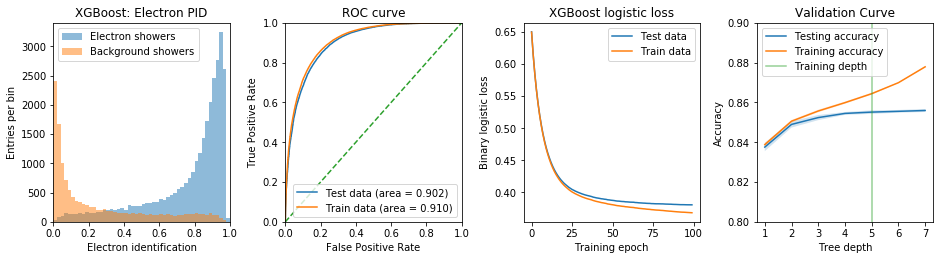

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_e.predict_proba(X_test).T[0]
y_pred_train = model_e.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Electron showers",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background showers",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Electron identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Electron PID")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_e.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax[3].set_title("Validation Curve")
ax[3].set_xlabel(r"Tree depth")
ax[3].set_ylabel("Accuracy")
ax[3].set_ylim(0.8, 0.9)
ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
ax[3].fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
)
ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
ax[3].fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
)
ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
ax[3].legend(loc="upper left")
ax[3].set_xticks(param_range)

fig.savefig(output_dir + "e_bdt_test.pdf")

#### Other daughters training

In [31]:
train_q = "preselect & ~e_candidate"
X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_other]
    Y = sample_info[k]["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [32]:
# fit model on training data
if retrain:
    depth = 6
    model_d = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_d.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
    )
    dump(model_d, model_dir + "model_d.pckl")
else:
    model_d = load(model_dir + "model_d.pckl")

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-error:0.161844	validation_0-logloss:0.643429	validation_1-error:0.163645	validation_1-logloss:0.644397
[1]	validation_0-error:0.160957	validation_0-logloss:0.604301	validation_1-error:0.16231	validation_1-logloss:0.604052
[2]	validation_0-error:0.163026	validation_0-logloss:0.570117	validation_1-error:0.164482	validation_1-logloss:0.570622
[3]	validation_0-error:0.162381	validation_0-logloss:0.541789	validation_1-error:0.163913	validation_1-logloss:0.542376
[4]	validation_0-error:0.162102	validation_0-logloss:0.517592	validation_1-error:0.163471	validation_1-logloss:0.518555
[5]	validation_0-error:0.161684	validation_0-logloss:0.497326	validation_1-error:0.163353	validation_1-logloss:0.49866
[6]	validation_0-error:0.160942	validation_0-logloss:0.479656	validation_1-error:0.16246	validation_1-logloss:0.481029
[7]	validation_0-error:0.160818	validation_0-logloss:0.464551	validation_1-error:0.162302	validation_1-logloss:0.465921
[8]	validation_0-error:0.160684	validation_

[68]	validation_0-error:0.158801	validation_0-logloss:0.359787	validation_1-error:0.161323	validation_1-logloss:0.365659
[69]	validation_0-error:0.158804	validation_0-logloss:0.359697	validation_1-error:0.161323	validation_1-logloss:0.365663
[70]	validation_0-error:0.158812	validation_0-logloss:0.359626	validation_1-error:0.161347	validation_1-logloss:0.36564
[71]	validation_0-error:0.158749	validation_0-logloss:0.359594	validation_1-error:0.161276	validation_1-logloss:0.365625
[72]	validation_0-error:0.158794	validation_0-logloss:0.359509	validation_1-error:0.161331	validation_1-logloss:0.365582
[73]	validation_0-error:0.158762	validation_0-logloss:0.359482	validation_1-error:0.161315	validation_1-logloss:0.365574
[74]	validation_0-error:0.158741	validation_0-logloss:0.359412	validation_1-error:0.161323	validation_1-logloss:0.365535
[75]	validation_0-error:0.158733	validation_0-logloss:0.359377	validation_1-error:0.161292	validation_1-logloss:0.365532
[76]	validation_0-error:0.158736	

<IPython.core.display.Javascript object>

In [33]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                       precision    recall  f1-score   support

    proton, pion, ...       0.87      0.87      0.87     81202
muon, overlay, photon       0.77      0.78      0.78     45432

             accuracy                           0.84    126634
            macro avg       0.82      0.83      0.83    126634
         weighted avg       0.84      0.84      0.84    126634

Test accuracy: 83.89%
Train accuracy: 84.16%

1. feature trk_llr_pid_score_v (0.616502)
2. feature trk_distance_v (0.199922)
3. feature trk_score_v (0.089212)
4. feature pfp_trk_daughters_v (0.040144)
5. feature pfp_generation_v (0.036762)
6. feature pfp_shr_daughters_v (0.017458)


<IPython.core.display.Javascript object>

In [34]:
param_range = range(1, 8)
train_scores, test_scores = validation_curve(
    XGBClassifier(),
    X_train,
    y_train["train_label"],
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
    cv=2,
)

<IPython.core.display.Javascript object>

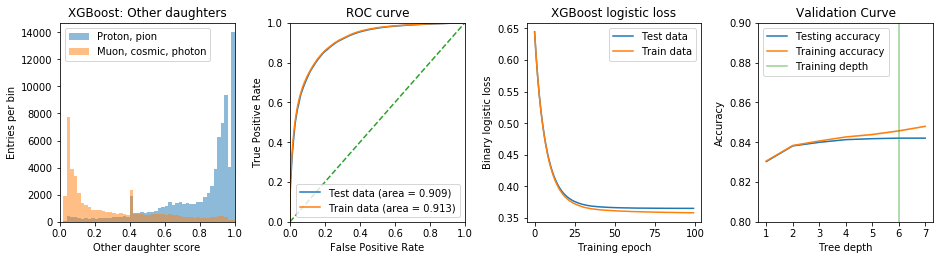

<IPython.core.display.Javascript object>

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_d.predict_proba(X_test).T[0]
y_pred_train = model_d.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["train_label"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["train_label"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["train_label"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"Proton, pion",
    density=False,
)
ax[0].hist(
    y_pred[y_test["train_label"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Muon, cosmic, photon",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Other daughter score")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Other daughters")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_d.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax[3].set_title("Validation Curve")
ax[3].set_xlabel(r"Tree depth")
ax[3].set_ylabel("Accuracy")
ax[3].set_ylim(0.8, 0.9)
ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
ax[3].fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
)
ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
ax[3].fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
)
ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
ax[3].legend(loc="upper left")
ax[3].set_xticks(param_range)

fig.savefig(output_dir + "daughter_bdt_test.pdf")

#### Apply models on the samples!

In [36]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    v["daughters"]["score"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score"] = model_e.predict_proba(
        v["daughters"][col_train_electron][mask_e_cand]
    ).T[1]
    mask_d = v["daughters"].eval("preselect & ~e_candidate")
    v["daughters"].loc[mask_d, "score"] = model_d.predict_proba(
        v["daughters"][col_train_other][mask_d]
    ).T[1]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


<IPython.core.display.Javascript object>

#### Train on the events

In [37]:
%%time
# First we need to add some columns:
for k, v in sample_info.items():    
    print(k)
    grouper = 'event'
    if k=='train':
        grouper = ['event', 'sample']
    
    mask_e = v["daughters"].eval("preselect & e_candidate & n_pfps>1")
    v["daughters"]["score_other_max"] = 1
    
    v["daughters"].loc[mask_e, "score_other_max"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .max()
        .values
    )
    v["daughters"]["score_other_mean"] = 1
    v["daughters"].loc[mask_e, "score_other_mean"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .mean()
        .values
    )
    v["daughters"]["score_other_min"] = 1
    v["daughters"].loc[mask_e, "score_other_min"] = (
        v["daughters"]
        .query("~e_candidate & preselect")["score"]
        .groupby(grouper, sort=False)
        .min()
        .values
    )

nu
nue
on
off
dirt
train
CPU times: user 2.43 s, sys: 347 ms, total: 2.77 s
Wall time: 2.77 s


<IPython.core.display.Javascript object>

In [38]:
train_q = "preselect & e_candidate"

X_train = []
X_test = []
y_train = []
y_test = []
for k in ["train"]:
    X = sample_info[k]["daughters"].query(train_q)[col_train_event]
    Y = sample_info[k]["daughters"].query(train_q)[["nueccinc", "train_weight"]]
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

# Merge our two samples
X_train = pd.concat(X_train).reset_index(drop=True)
y_train = pd.concat(y_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
y_test = pd.concat(y_test).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [39]:
# fit model on training data\
if retrain:
    depth = 5
    model_event = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["nueccinc"]), (X_test, y_test["nueccinc"])]
    model_event.fit(
        X_train,
        y_train["nueccinc"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
    )
    dump(model_event, model_dir + "model_event.pckl")
else:
    model_event = load(model_dir + "model_event.pckl")

[0]	validation_0-error:0.159348	validation_0-logloss:0.639034	validation_1-error:0.164732	validation_1-logloss:0.63987


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	validation_0-error:0.152668	validation_0-logloss:0.594656	validation_1-error:0.158631	validation_1-logloss:0.596307
[2]	validation_0-error:0.153826	validation_0-logloss:0.557819	validation_1-error:0.159591	validation_1-logloss:0.560012
[3]	validation_0-error:0.152805	validation_0-logloss:0.526881	validation_1-error:0.157602	validation_1-logloss:0.529856
[4]	validation_0-error:0.152706	validation_0-logloss:0.500797	validation_1-error:0.158471	validation_1-logloss:0.504483
[5]	validation_0-error:0.151708	validation_0-logloss:0.47817	validation_1-error:0.157237	validation_1-logloss:0.48245
[6]	validation_0-error:0.150809	validation_0-logloss:0.45923	validation_1-error:0.156574	validation_1-logloss:0.464013
[7]	validation_0-error:0.150147	validation_0-logloss:0.442865	validation_1-error:0.156323	validation_1-logloss:0.447904
[8]	validation_0-error:0.149065	validation_0-logloss:0.428547	validation_1-error:0.15502	validation_1-logloss:0.434114
[9]	validation_0-error:0.149156	validation_0

[70]	validation_0-error:0.141798	validation_0-logloss:0.318575	validation_1-error:0.148188	validation_1-logloss:0.332452
[71]	validation_0-error:0.141684	validation_0-logloss:0.31823	validation_1-error:0.148028	validation_1-logloss:0.332182
[72]	validation_0-error:0.141509	validation_0-logloss:0.31807	validation_1-error:0.147959	validation_1-logloss:0.332107
[73]	validation_0-error:0.141517	validation_0-logloss:0.317994	validation_1-error:0.148119	validation_1-logloss:0.332112
[74]	validation_0-error:0.141478	validation_0-logloss:0.317799	validation_1-error:0.148097	validation_1-logloss:0.331943
[75]	validation_0-error:0.141456	validation_0-logloss:0.31773	validation_1-error:0.148097	validation_1-logloss:0.33192
[76]	validation_0-error:0.141433	validation_0-logloss:0.317536	validation_1-error:0.148051	validation_1-logloss:0.331849
[77]	validation_0-error:0.141159	validation_0-logloss:0.31726	validation_1-error:0.148051	validation_1-logloss:0.331717
[78]	validation_0-error:0.14109	valid

<IPython.core.display.Javascript object>

In [40]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nueccinc"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nueccinc"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nueccinc"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

                   precision    recall  f1-score   support

         nueccinc       0.90      0.87      0.89     29371
background events       0.76      0.81      0.78     14391

         accuracy                           0.85     43762
        macro avg       0.83      0.84      0.84     43762
     weighted avg       0.86      0.85      0.85     43762

Test accuracy: 85.31%
Train accuracy: 85.99%

1. feature score (0.679704)
2. feature score_other_min (0.157629)
3. feature contained_fraction (0.040859)
4. feature n_showers (0.035973)
5. feature hits_ratio (0.033746)
6. feature score_other_mean (0.032446)
7. feature n_pfp_farvtx (0.019643)


<IPython.core.display.Javascript object>

In [41]:
param_range = range(1, 8)
train_scores, test_scores = validation_curve(
    XGBClassifier(),
    X_train,
    y_train["nueccinc"],
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


<IPython.core.display.Javascript object>

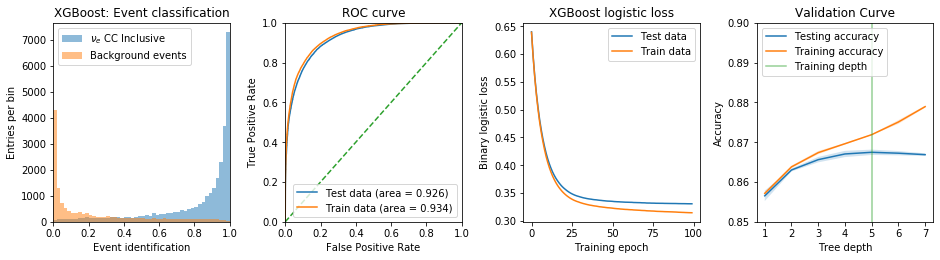

<IPython.core.display.Javascript object>

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(8 * 1.618, 3.5), constrained_layout=True)

y_pred = model_event.predict_proba(X_test).T[0]
y_pred_train = model_event.predict_proba(X_train).T[0]
fpr, tpr, _ = roc_curve(y_test["nueccinc"], y_pred)
fpr_train, tpr_train, _ = roc_curve(y_train["nueccinc"], y_pred_train)
roc_auc = auc(tpr, fpr)
roc_auc_train = auc(tpr_train, fpr_train)

ax[0].hist(
    y_pred[y_test["nueccinc"] == 0],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label=r"$\nu_e$ CC Inclusive",
    density=False,
)
ax[0].hist(
    y_pred[y_test["nueccinc"] == 1],
    alpha=0.5,
    bins=50,
    range=(0, 1),
    label="Background events",
    density=False,
)
ax[0].legend(loc="upper left")
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Event identification")
ax[0].set_ylabel("Entries per bin")
ax[0].set_title("XGBoost: Event classification")


ax[1].plot(tpr, fpr, label="Test data (area = %0.3f)" % roc_auc)
ax[1].plot(tpr_train, fpr_train, label="Train data (area = %0.3f)" % roc_auc_train)
ax[1].plot([0, 1], [0, 1], linestyle="--")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC curve")
ax[1].legend(loc="lower right")


# retrieve performance metrics
results = model_event.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)
# plot log loss
ax[2].plot(x_axis, results["validation_1"]["logloss"], label="Test data")
ax[2].plot(x_axis, results["validation_0"]["logloss"], label="Train data")
ax[2].legend()
ax[2].set_ylabel("Binary logistic loss")
ax[2].set_xlabel("Training epoch")
ax[2].set_title("XGBoost logistic loss")


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax[3].set_title("Validation Curve")
ax[3].set_xlabel(r"Tree depth")
ax[3].set_ylabel("Accuracy")
ax[3].set_ylim(0.85, 0.9)
ax[3].plot(param_range, test_scores_mean, label="Testing accuracy")
ax[3].fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
)
ax[3].plot(param_range, train_scores_mean, label="Training accuracy")
ax[3].fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
)
ax[3].axvline(x=depth, label="Training depth", color="C2", alpha=0.5)
ax[3].legend(loc="upper left")
ax[3].set_xticks(param_range)

fig.savefig(output_dir + "event_bdt_test.pdf")

In [ ]:
%time
# add the columns for each daughter (all samples)
for k, v in sample_info.items():
    print(k)
    v["daughters"]["score_event"] = -1
    mask_e_cand = v["daughters"].eval("preselect & e_candidate")
    v["daughters"].loc[mask_e_cand, "score_event"] = model_event.predict_proba(
        v["daughters"][col_train_event][mask_e_cand]
    ).T[1]

In [ ]:
# Get rid of this one annoying duplicated event
if run == 3:
    sample_info["on"]["daughters"].drop([14558, 15192], level="event", inplace=True)

In [ ]:
cut_val = 0.915
query_select = "e_candidate & preselect & score_event>@cut_val"
# Passing rate selection
for k, v in sample_info.items():
    grouper = "event"
    if k == "train":
        grouper = ["event", "sample"]
    v["daughters"]["select"] = v["daughters"].eval(query_select)
    v["daughters"]["select"] = (
        v["daughters"]["select"].groupby(grouper, sort=False).transform(max)
    )

    pass_rate = sum(v["daughters"].eval("(e_candidate & select)")) / v["numentries"]
    print(k, "\t{:.4f}%".format(pass_rate * 100))

# Passing rate signal, weights applied!
pass_rate = sum(
    sample_info["nue"]["daughters"].eval("(e_candidate & select)*weightSpline*nueccinc")
) / sum(sample_info["nue"]["mc"]["weightSpline"] * sample_info["nue"]["mc"]["nueccinc"])
print("nue signal passing the selection \t{:.2f}%".format(pass_rate * 100))
nue_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print(
    "nue Intrinsic signal passing: {0:0.3f} per {1:0.2g} POT".format(
        nue_pass, pot_target
    )
)
lee_pass = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*leeweight*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    * pot_scale
)
print("nue LEE signal passing: {0:0.3f} per {1:0.2g} POT".format(lee_pass, pot_target))

## Calculate the purity:
purity_denom = (
    sum(sample_info["nu"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["nu"]["scaling"]
)
purity_denom += (
    sum(sample_info["dirt"]["daughters"].eval("(e_candidate & select)*weightSpline"))
    * sample_info["dirt"]["scaling"]
)
purity_denom += (
    sum(sample_info["off"]["daughters"].eval("(e_candidate & select)"))
    * sample_info["off"]["scaling"]
)

purity_mc = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / purity_denom
)
purity_data = (
    sum(
        sample_info["nue"]["daughters"].eval(
            "(e_candidate & select)*weightSpline*nueccinc"
        )
    )
    * sample_info["nue"]["scaling"]
    / sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
)
print(
    "Purity MC: {:.1f}%\nData/MC-ratio: {:.2f}\n".format(
        purity_mc * 100,
        sum(sample_info["on"]["daughters"].eval("(e_candidate & select)"))
        / purity_denom,
    )
)

In [ ]:
np.savetxt(
    output_dir + "events_run{}.txt".format(run),
    sample_info["on"]["daughters"].query("(e_candidate & select)")[
        ["run", "sub", "evt"]
    ],
    fmt="%u",
)
sample_info["on"]["daughters"].query("(e_candidate & select)")

In [ ]:
sample_info["on"]["daughters"].query("(e_candidate & preselect)")["score_event"].hist(
    range=(0.8, 1), bins=24
)
plt.axvline(x=cut_val, c="r")

In [ ]:
cols_to_pickle = [
    "run",
    "sub",
    "evt",
    "topological_score",
    "n_pfps",
    "n_showers",
    "n_tracks",
    "reco_nu_vtx_x",
    "reco_nu_vtx_y",
    "reco_nu_vtx_z",
    "reco_nu_vtx_sce_x",
    "reco_nu_vtx_sce_y",
    "reco_nu_vtx_sce_z",
    "crtveto",
    "crthitpe",
    "slclustfrac",
    "hits_ratio",
    "CosmicIP",
    "contained_sps_ratio",
    "contained_fraction",
    "slpdg",
    "SliceCaloEnergy2",
    "NeutrinoEnergy2",
    "trk_score_v",
    "trk_distance_v",
    "trk_theta_v",
    "trk_phi_v",
    "trk_len_v",
    "trk_llr_pid_score_v",
    "trk_mcs_muon_mom_v",
    "trk_calo_energy_y_v",
    "trk_sce_end_x_v",
    "trk_sce_end_y_v",
    "trk_sce_end_z_v",
    "trk_sce_start_x_v",
    "trk_sce_start_y_v",
    "trk_sce_start_z_v",
    "trk_start_x_v",
    "trk_start_y_v",
    "trk_start_z_v",
    "shr_energy_y_v",
    "shr_energy_u_v",
    "shr_energy_v_v",
    "shr_phi_v",
    "shr_theta_v",
    "shr_tkfit_start_x_v",
    "shr_tkfit_start_y_v",
    "shr_tkfit_start_z_v",
    "shr_start_x_v",
    "shr_start_y_v",
    "shr_start_z_v",
    "shr_tkfit_theta_v",
    "shr_tkfit_phi_v",
    "shr_tkfit_dedx_u_v",
    "shr_tkfit_dedx_v_v",
    "shr_tkfit_dedx_y_v",
    "shr_tkfit_gap10_dedx_y_v",
    "shr_tkfit_nhits_v",
    "shr_tkfit_dedx_nhits_y_v",
    "shr_moliere_avg_v",
    "shr_moliere_rms_v",
    "pfnplanehits_Y",
    "pfpplanesubclusters_Y",
    "pfpplanesubhitfracmax_Y",
    "pfnhits",
    "pfp_generation_v",
    "pfp_trk_daughters_v",
    "pfp_shr_daughters_v",
    "true_nu_vtx_x",
    "true_nu_vtx_y",
    "true_nu_vtx_z",
    "true_nu_vtx_sce_x",
    "true_nu_vtx_sce_y",
    "true_nu_vtx_sce_z",
    "nu_e",
    "lep_e",
    "nu_pdg",
    "nelec",
    "npion",
    "npi0",
    "nproton",
    "nmuon",
    "theta",
    "ccnc",
    "interaction",
    "weightSpline",
    "weightSplineTimesTune",
    "leeweight",
    "nu_completeness_from_pfp",
    "nu_purity_from_pfp",
    "backtracked_pdg",
    "backtracked_e",
    "backtracked_completeness",
    "backtracked_purity",
    "backtracked_overlay_purity",
    "backtracked_px",
    "backtracked_py",
    "backtracked_pz",
    "backtracked_sce_start_x",
    "backtracked_sce_start_y",
    "backtracked_sce_start_z",
    "trk_min_cos",
    "nueccinc",
    "true_category",
    "reco_fid_vol",
    "all_start_contained",
    "all_end_contained",
    "n_pfpvtx",
    "n_pfp_farvtx",
    "shr_dist_v",
    "e_candidate",
    "shr_tkfit_dedx_wm_v",
    "hits_per_tklen_v",
    "shr_subclusters_v",
    "shr_tkfit_hitratio_v",
    "mu_candidate",
    "mu_candidate_event",
    "true_vtx_distance",
    "true_vtx_distance_check",
    "true_shower_distance",
    "_closestNuCosmicDist",
    "preselect",
    "score",
    "score_other_max",
    "score_other_mean",
    "score_other_min",
    "score_event",
    "select",
    "ismerged",
    "merge_bestdist",
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
]

In [ ]:
print([x for x in cols_to_pickle if cols_to_pickle.count(x) > 1])

In [ ]:
write_output_to_pickle = False
if write_output_to_pickle:
    for sample in list(sample_info.keys()):
        if sample in plot_samples:
            print(sample)
            columns_to_drop = set(sample_info[sample]["daughters"].keys()) - set(
                cols_to_pickle
            )
            sample_info[sample]["daughters"].drop(columns_to_drop, inplace=True, axis=1)
        else:
            del sample_info[sample]
    pickle_out = open(input_dir + "after_training_run{}.pckl".format(run), "wb")
    pickle.dump(sample_info, pickle_out)
    pickle_out.close()

### Plots

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")["true_vtx_distance_check"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_x+@x_sce_magic-reco_nu_vtx_sce_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[1].hist(
    sample_info["nue"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")
    .eval("true_nu_vtx_sce_x-reco_nu_vtx_x"),
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx_sce - reco_nu_vtx|",
    alpha=0.7,
)
ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "vtx_distance.pdf")